In [1]:
# Importing Keras 
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer 
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [2]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# Efficient Looping
import itertools

# Traceback for diagnosis
import traceback

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest
import math

# Feature Selection
from sklearn.feature_selection import (
    RFECV, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin

# Preprocessing data
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Model Selection for Cross Validation
from sklearn.model_selection import (
    StratifiedKFold, KFold, 
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, TimeSeriesSplit
)

# Machine Learning metrics
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    cohen_kappa_score,
    make_scorer,
    roc_curve,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# ML regressors
from sklearn.linear_model import HuberRegressor,RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import (
    HistGradientBoostingRegressor, StackingRegressor, 
    AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, StackingRegressor, VotingRegressor
    )
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# ML classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier, 
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier,ExtraTreesClassifier
    )
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Clustering algorithms
from sklearn.cluster import KMeans

# Fine-tuning 
import optuna

# Randomizer
import random

# Encoder of categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# OS
import os

# Image package
from PIL import Image

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

f:\plant-disease-recognition\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'
#colormap = 
#template = 

In [4]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)
    
    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))
        
    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()

In [5]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")  
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [6]:
# Loading training, testing, and validation directories
train_dir = './dataset/Train/Train'
test_dir = './dataset/Test/Test'
val_dir = './dataset/Validation/Validation'


In [7]:
# Giving names to each directory
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
    }

# Naming subfolders
subfolders = ['Healthy', 'Powdery', 'Rust']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Train/Healthy: 458



Train/Powdery: 430

Train/Rust: 434

  Total: 1322
--------------------------------------------------------------------------------

Test/Healthy: 50

Test/Powdery: 50

Test/Rust: 50

  Total: 150
--------------------------------------------------------------------------------

Validation/Healthy: 20

Validation/Powdery: 20

Validation/Rust: 20

  Total: 60
--------------------------------------------------------------------------------


In [8]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)
                
if len(unique_dimensions) == 1:
    print(f"\nAll images have the same dimensions: {unique_dimensions.pop()}")
else:
    print(f"\nFound {len(unique_dimensions)} unique image dimensions: {unique_dimensions}")


Found 8 unique image dimensions: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


In [9]:
# Checking if all the images in the dataset have the same dimensions
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1
                
for dimension, count in dims_counts.items():
    print(f"\nDimension {dimension}: {count} images")


Dimension (4000, 3000): 88 images

Dimension (4000, 2672): 1130 images

Dimension (2421, 2279): 1 images

Dimension (2592, 1728): 127 images

Dimension (5184, 3456): 97 images

Dimension (4608, 3456): 72 images

Dimension (4032, 3024): 16 images

Dimension (3901, 2607): 1 images


In [10]:
# Checking images dtype
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)
        
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)
                
            if img_array.dtype == 'uint8':
                all_uint8 = False
            
            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False
                
if all_uint8:
    print(" - All images are of data type uint8\n")
else:
    print(" - Not all images are of data type uint8\n")
    
if all_in_range:
    print(" - All images have pixel values ranging from 0 to 255")
else:
    print(" - Not all images have the same pixel values from 0 to 255")

 - Not all images are of data type uint8

 - All images have pixel values ranging from 0 to 255


In [11]:
# Loading the directory for each class in the training dataset
train_healthy_dir = train_dir + "/" + 'Healthy'
train_rust_dir = train_dir + "/" + 'Rust'
train_powdery_dir = train_dir + "/" + 'Powdery'

# Selecting 9 random pictures from each directory
healthy_files = random.sample(os.listdir(train_healthy_dir), 9)
rust_files = random.sample(os.listdir(train_rust_dir), 9)
powdery_files = random.sample(os.listdir(train_powdery_dir), 9)

In [12]:
# Plotting healthy plants
healthy_images = [os.path.join(train_healthy_dir, f) for f in healthy_files]
# plot_images_list(healthy_images, "Healthy Plants", "Training Dataset")

In [13]:
# Plotting rust plants
rust_images = [os.path.join(train_rust_dir, f) for f in rust_files]
# plot_images_list(rust_images, "Rust Plants", "Training Dataset")

In [14]:
# Plotting powdery plants
powdery_images = [os.path.join(train_powdery_dir, f) for f in powdery_files]
# plot_images_list(powdery_images, "Powdery Plants", "Training Dataset")

In [15]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 1322 files belonging to 3 classes.


In [16]:
# Creating a Dataset for the Training data
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 150 files belonging to 3 classes.


In [17]:
# Creating a dataset for the Test data
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    
    image_size = (256, 256),
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 60 files belonging to 3 classes.


In [18]:
print('\nTraining Dataset:', train)
print('\nTesting Dataset:', test)
print('\nValidation Dataset:', validation)


Training Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Testing Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [19]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 255.0


In [20]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1

In [21]:
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y)) 
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [22]:
# Checking minimum and maximum pixel values in the Validation dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)
    
    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())
    
print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


In [23]:
# Creating data augmentation pipeline
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),
        
        
        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),
        
        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

In [24]:
augmentation.build((None, 256, 256, 3)) # Building model
# Plotting model
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
# Initiating model on GPU
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Adding data augmentation pipeline to the model

    # Feature Learning Layers
    model.add(Conv2D(32,                  # Number of filters/Kernels
                     (3,3),               # Size of kernels (3x3 matrix)
                     strides = 1,         # Step size for sliding the kernel across the input (1 pixel at a time).
                     padding = 'same',    # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                    input_shape = (256,256,3) # Input image shape
                    ))
    model.add(Activation('relu'))# Activation function
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # Flattening tensors
    model.add(Flatten())

    # Fully-Connected Layers
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation = 'softmax')) # Classification layer

In [26]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [27]:
# Training and Testing Model
try:
    history = model.fit(
        train, epochs = 7,
        validation_data = test,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

Epoch 1/7
83/83 [==============================] - 460s 5s/step - loss: 32.7605 - accuracy: 0.5121 - val_loss: 25.0583 - val_accuracy: 0.3533
Epoch 2/7
83/83 [==============================] - 402s 5s/step - loss: 21.0347 - accuracy: 0.6256 - val_loss: 10.6387 - val_accuracy: 0.4667
Epoch 3/7
83/83 [==============================] - 389s 5s/step - loss: 11.7978 - accuracy: 0.7103 - val_loss: 9.5782 - val_accuracy: 0.4267
Epoch 4/7
83/83 [==============================] - 414s 5s/step - loss: 4.7604 - accuracy: 0.7912 - val_loss: 1.0356 - val_accuracy: 0.6800
Epoch 5/7
83/83 [==============================] - 425s 5s/step - loss: 2.5624 - accuracy: 0.8162 - val_loss: 1.3378 - val_accuracy: 0.7867
Epoch 6/7
83/83 [==============================] - 517s 6s/step - loss: 1.5406 - accuracy: 0.8238 - val_loss: 1.1995 - val_accuracy: 0.6533
Epoch 7/7
83/83 [==============================] - 495s 6s/step - loss: 0.8926 - accuracy: 0.8616 - val_loss: 0.7498 - val_accuracy: 0.8533


In [40]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

In [29]:
tf.keras.utils.plot_model(model) # Plotting model 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
model.summary() # Printing model summary


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)     

In [31]:
# Loading best weights
model.load_weights('best_model.h5')

In [32]:
preds = model.predict(validation)  # Running model on the validation dataset
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

4/4 [==============================] - 4s 687ms/step - loss: 0.2759 - accuracy: 0.9167

Validation Loss:  0.27585986256599426

Validation Accuracy:  92.0 %


Picture of a Powdery Plant: 



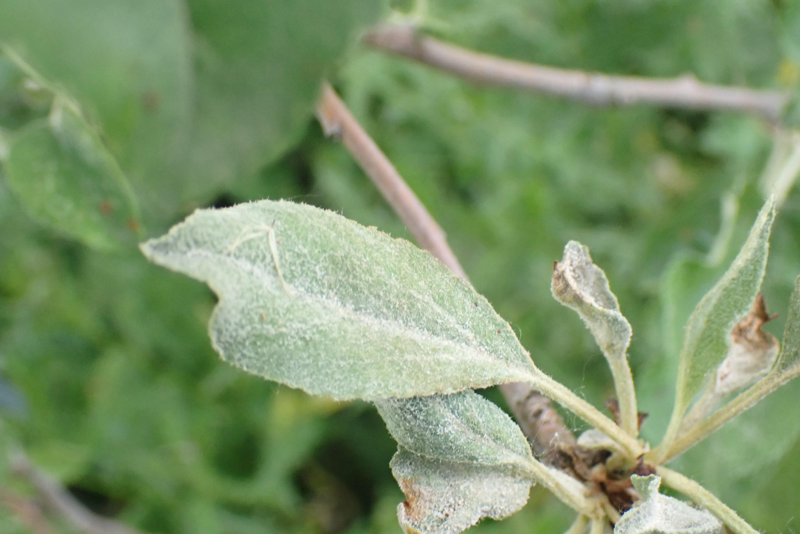

In [33]:
# Loading an image from the Validation/ Powdery directory
image_path = './dataset/Validation/Validation/Powdery/9b6a318cc5721d73.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Powdery Plant: \n')
resized_img

In [34]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 1s 1s/step

Predicted Class: Powdery

Confidence Score: 0.9891195297241211


Picture of a Rust Plant: 



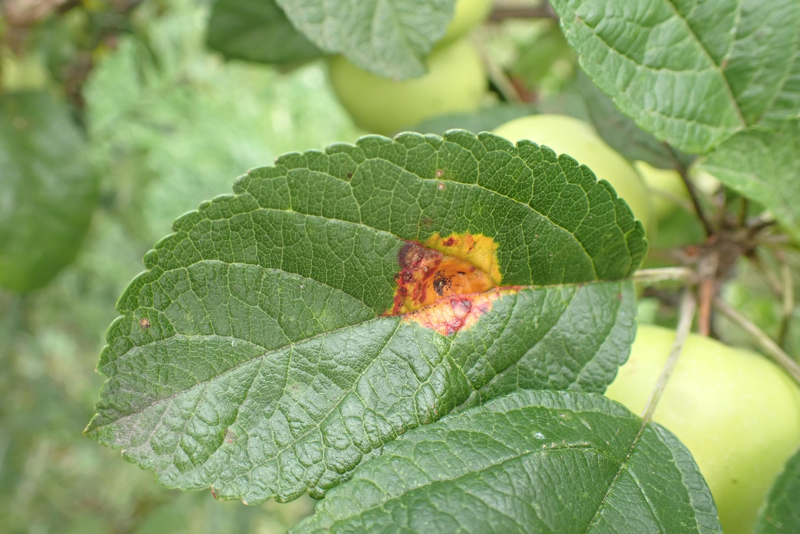

In [35]:
# Loading an image from the Validation/ Rust directory
image_path = './dataset/Validation/Validation/Rust/8152cfbd5a28b5d2.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Rust Plant: \n')
resized_img

In [36]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 123ms/step

Predicted Class: Rust

Confidence Score: 1.0


Picture of a Healthy Plant: 



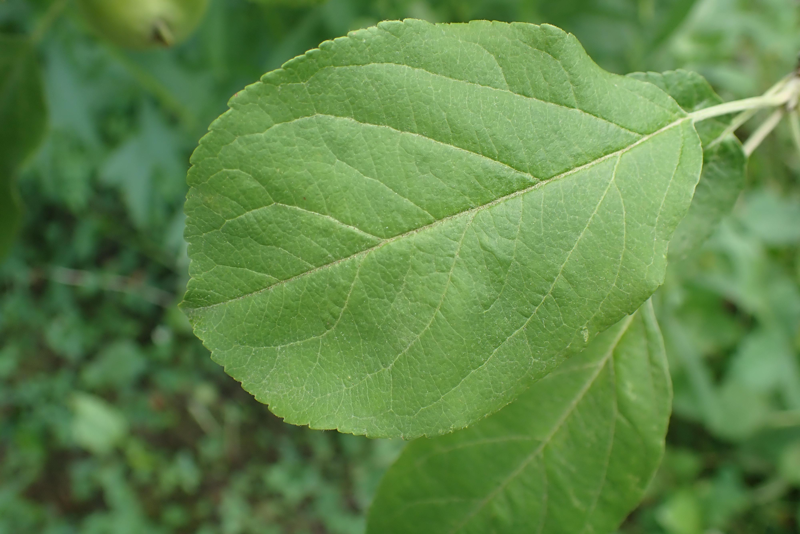

In [37]:
# Loading an image from the Validation/ Healthy directory
image_path = './dataset/Validation/Validation/Healthy/9c99786a63786571.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing image for optimal performance
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Picture of a Healthy Plant: \n')
resized_img

In [38]:
# Manually preprocessing image
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nPredicted Class: {preds_label}')
print(f'\nConfidence Score: {preds[0][preds_class]}')

1/1 [==============================] - 0s 149ms/step

Predicted Class: Healthy

Confidence Score: 0.962505042552948


In [39]:
model.save('plant_disease_classifier.h5') # Saving model